<a href="https://colab.research.google.com/github/Erik-M-Larsson/Deep_learning/blob/main/Lab/lab_1-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboration deep learning AI21


In [31]:
import os as os
import matplotlib.pyplot as plt
import random as rnd
import numpy as np
import seaborn as sns
import cv2
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


## 1. Bildbehandling 
### Läs in bilder från del 0


In [7]:
# Kontrollera om körningen sker i coolab
if os.path.abspath("") == "/content":
    !git clone https://github.com/Erik-M-Larsson/Deep_learning.git
    current_dir = os.path.abspath("Deep_learning/Lab")
    from Deep_learning.Lab.funktioner import paths_data_folders, read_images
else:
    current_dir = os.path.abspath("")
    from funktioner import paths_data_folders, read_images



Cloning into 'Deep_learning'...
remote: Enumerating objects: 2555, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 2555 (delta 13), reused 46 (delta 12), pack-reused 2508
Receiving objects: 100% (2555/2555), 64.95 MiB | 22.05 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [8]:
# läs in bilder
paths = paths_data_folders(current_dir)
x_train_small, x_val_small, x_test_small, y_train_small, y_val_small, y_test_small = read_images(paths[0:3])

### a)

In [12]:
dimensioner_bilder = tuple(zip(*[x.shape[0:2] for x in x_train_small]))


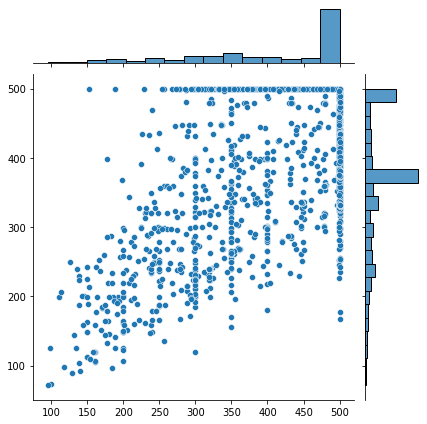

In [13]:
kinds = ['scatter', 'hist', 'hex', 'kde', 'reg', 'resid']
sns.jointplot(x=dimensioner_bilder[1], y=dimensioner_bilder[0], kind=kinds[0]);

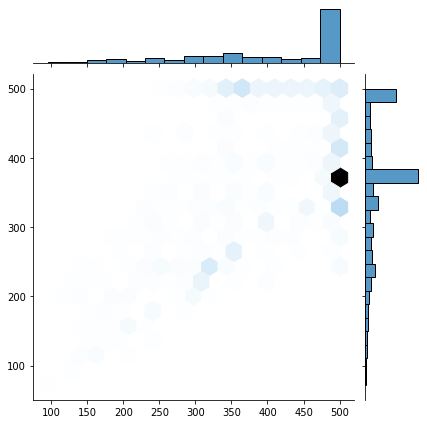

In [14]:
sns.jointplot(x=dimensioner_bilder[1], y=dimensioner_bilder[0], kind=kinds[2]);

### b)

(100, 100, 3)

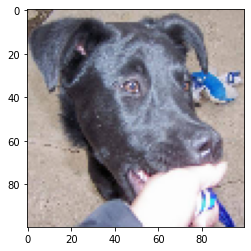

In [15]:
idx_testa =1

ratio = 1 #375/500

bredd = 100
höjd = int(ratio*bredd)

testbild = cv2.resize(x_train_small[idx_testa], (bredd, höjd),)
plt.imshow(testbild)

testbild.shape


(384, 449, 3)

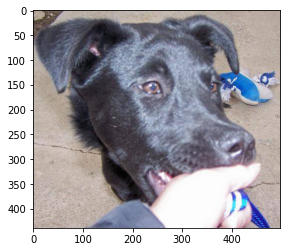

In [16]:
plt.imshow(x_train_small[idx_testa])
x_test_small[idx_testa].shape

### c)

In [17]:
def skala_om_bilder(bilder: list):
    return [cv2.resize(bild, (bredd, höjd),) for bild in bilder]

In [18]:
x_train_resized_small =  np.array(skala_om_bilder(x_train_small), dtype=np.float32)/255
x_val_resized_small =  np.array(skala_om_bilder(x_val_small), dtype=np.float32)/255
x_test_resized_small =  np.array(skala_om_bilder(x_test_small), dtype=np.float32)/255


In [19]:
x_train_resized_small.shape


(1600, 100, 100, 3)

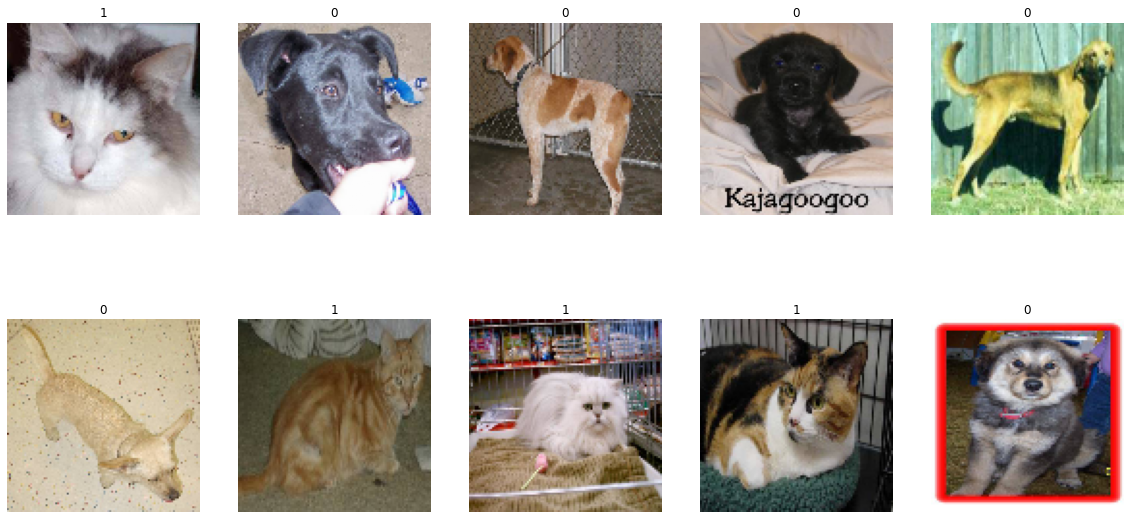

In [20]:
fig, axes = plt.subplots(2, 5)
fig.set_size_inches(20,10)

for x, y, ax in zip(x_train_resized_small, y_train_small, axes.flatten()):

    ax.imshow(x)
    ax.set_title(f"{y}")    
    ax.axis("off")

### d)

In [21]:
augmented_image_generator = ImageDataGenerator(
    rotation_range=10,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=False,
    height_shift_range=0.2,
    width_shift_range=0.2,
    
)

train_test_image_generator = ImageDataGenerator()



In [22]:
bildförvrängare = augmented_image_generator.flow(x_train_resized_small, y_train_small, batch_size = len(x_train_resized_small))

bildförvrängare[0][0].shape


(1600, 100, 100, 3)

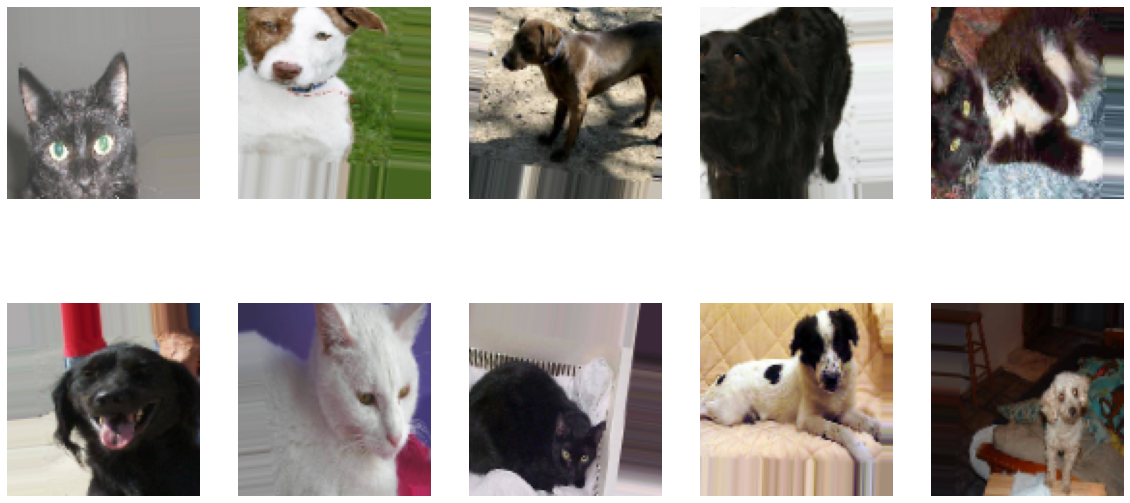

In [23]:
fig, axes = plt.subplots(2, 5)
fig.set_size_inches(20,10)

for x, y, ax in zip(bildförvrängare[0][0], y_train_small, axes.flatten()):

    ax.imshow(x)
    #ax.set_title(f"{y}")    
    ax.axis("off")

In [24]:
# Utöka antalet bilder
x_train_augmented_small = x_train_resized_small.copy() 
y_train_augmented_small = y_train_small.copy()

faktor_fler_bilder = 5

for bilder,_ in zip(bildförvrängare, range(faktor_fler_bilder-1)):

    x_train_augmented_small = np.concatenate((x_train_augmented_small,  bilder[0]))
    y_train_augmented_small = np.concatenate((y_train_augmented_small,  bilder[1]))
    
    
x_train_augmented_small.shape, y_train_augmented_small.shape


((8000, 100, 100, 3), (8000,))

In [25]:
# Randomisera ordningen
indices = np.arange(x_train_augmented_small.shape[0])
np.random.shuffle(indices)

x_train_augmented_small = x_train_augmented_small[indices]
y_train_augmented_small = y_train_augmented_small[indices]

x_train_augmented_small.shape, y_train_augmented_small.shape

((8000, 100, 100, 3), (8000,))

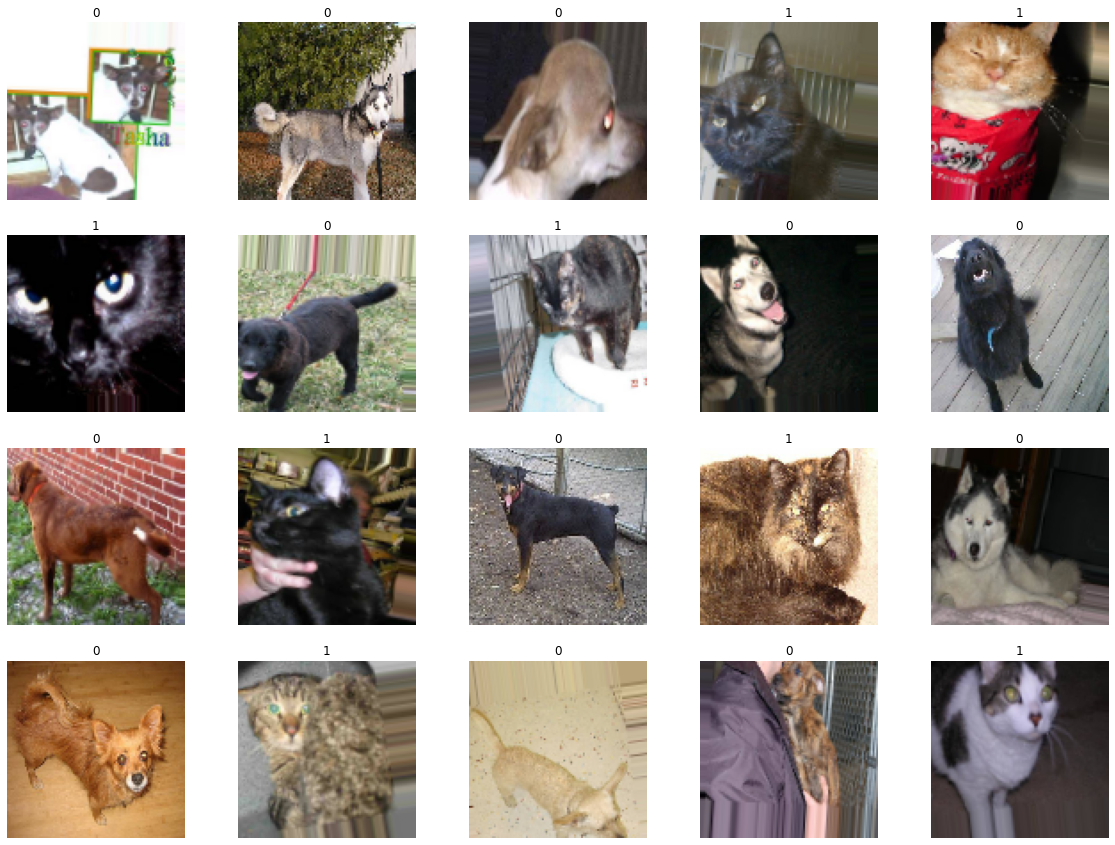

In [26]:
# Rita ut exempelbilder med etikett
fig, axes = plt.subplots(4, 5)
fig.set_size_inches(20,15)

for x, y, ax in zip(x_train_augmented_small, y_train_augmented_small, axes.flatten()):

    ax.imshow(x)
    ax.set_title(f"{y}")    
    ax.axis("off")

## 2. Träna modeller
### a)

In [27]:

def CNN_model( input_shape, learning_rate=0.001, drop_rate=0.3, kernels=[32, 64, 128, 128]):
    adam = Adam(learning_rate=learning_rate)
    model = Sequential(name="CNN_model")


    for number_kernel in kernels:
            conv_layer = Conv2D(
                number_kernel,
                kernel_size=(3, 3),
                activation="relu",
                kernel_initializer="he_normal",
                input_shape=input_shape,
            )

            model.add(conv_layer)
            
            model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))

    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(512, activation="relu", kernel_initializer="he_normal"))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(
            loss="binary_crossentropy", optimizer=adam, metrics=["acc"]
        )
    return model


In [28]:
def apa(x_train, x_val, y_train, y_val, epochs= 100, batch_size = 32, patience = 5, **kwargs):
    model = CNN_model(input_shape=x_train.shape[1:], **kwargs) 

    steps_per_epoch = int(len(x_train)/batch_size)
    validation_steps = int(len(x_val)/batch_size)

    early_stopper = EarlyStopping(
        monitor="val_acc", mode="max", patience=patience, restore_best_weights=True
    )

    train_generator = train_test_image_generator.flow(
        x_train, y_train, batch_size=batch_size
    )

    val_generator = train_test_image_generator.flow(
        x_val, y_val, batch_size=batch_size
    )

    model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        callbacks=[early_stopper],
        validation_data=val_generator,
        validation_steps=validation_steps,
    )

    metrics = pd.DataFrame(model.history.history)
    return metrics

In [29]:
def plot_metrics(metrics):
    _, ax = plt.subplots(1,2, figsize = (12,4))
    metrics[["loss", "val_loss"]].plot(ax = ax[0], title = "Loss", grid = True)
    metrics[["acc", "val_acc"]].plot(ax = ax[1], title = "Accuracy", grid = True)



Epoch 1/100
50/50 [==============================] - 2s 20ms/step - loss: 0.8612 - acc: 0.5156 - val_loss: 0.6902 - val_acc: 0.5208
Epoch 2/100
50/50 [==============================] - 1s 16ms/step - loss: 0.6794 - acc: 0.5556 - val_loss: 0.6764 - val_acc: 0.5573
Epoch 3/100
50/50 [==============================] - 1s 16ms/step - loss: 0.6780 - acc: 0.5619 - val_loss: 0.8384 - val_acc: 0.5052
Epoch 4/100
50/50 [==============================] - 1s 16ms/step - loss: 0.6569 - acc: 0.6175 - val_loss: 0.6961 - val_acc: 0.5547
Epoch 5/100
50/50 [==============================] - 1s 16ms/step - loss: 0.6373 - acc: 0.6263 - val_loss: 0.7012 - val_acc: 0.5573
Epoch 6/100
50/50 [==============================] - 1s 17ms/step - loss: 0.6288 - acc: 0.6444 - val_loss: 0.6682 - val_acc: 0.5833
Epoch 7/100
50/50 [==============================] - 1s 16ms/step - loss: 0.6162 - acc: 0.6619 - val_loss: 0.6756 - val_acc: 0.5911
Epoch 8/100
50/50 [==============================] - 1s 16ms/step - loss: 0.

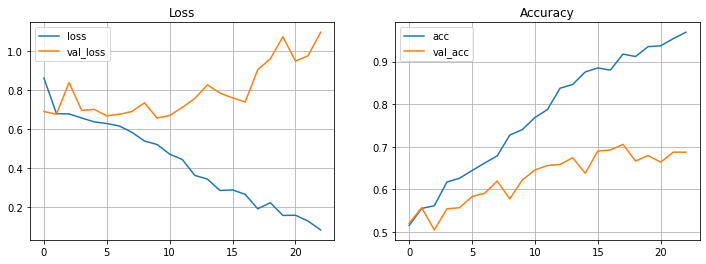

In [32]:
# Utan augmentering
metrics = apa(x_train_resized_small, x_val_resized_small, y_train_small, y_val_small)
plot_metrics(metrics)

In [33]:
# Med augmentering
metrics = apa(x_train_augmented_small, x_val_resized_small, y_train_augmented_small, y_val_small)
plot_metrics(metrics)

Epoch 1/100
250/250 [==============================] - 4s 15ms/step - loss: 0.7299 - acc: 0.5307 - val_loss: 0.6899 - val_acc: 0.5052
Epoch 2/100
177/250 [====================>.........] - ETA: 0s - loss: 0.6751 - acc: 0.5558

KeyboardInterrupt: ignored

In [34]:
# Testa olika learning rate och drop rate

learning_rates =  [0.01, 0.005, 0.001, 0.0005, 0.0001]
drop_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

metrics_grid =[]
for i, lr in enumerate(learning_rates):
    metrics_row = []
    for j, dr in enumerate(drop_rates):
        metrics = apa(x_train_resized_small, x_val_resized_small, y_train_small, y_val_small, learning_rate=lr, drop_rate=dr, patience=7)
        metrics_row.append(metrics)
        
    metrics_grid.append(metrics_row)

Epoch 1/100
50/50 [==============================] - 2s 22ms/step - loss: 10.6232 - acc: 0.5025 - val_loss: 0.6916 - val_acc: 0.5677
Epoch 2/100
50/50 [==============================] - 1s 16ms/step - loss: 0.6905 - acc: 0.5263 - val_loss: 0.6978 - val_acc: 0.4896
Epoch 3/100
50/50 [==============================] - 1s 15ms/step - loss: 0.6952 - acc: 0.4775 - val_loss: 0.6932 - val_acc: 0.5078
Epoch 4/100
50/50 [==============================] - 1s 16ms/step - loss: 0.6938 - acc: 0.4931 - val_loss: 0.6936 - val_acc: 0.4948
Epoch 5/100
13/50 [======>.......................] - ETA: 0s - loss: 0.6922 - acc: 0.4976

KeyboardInterrupt: ignored

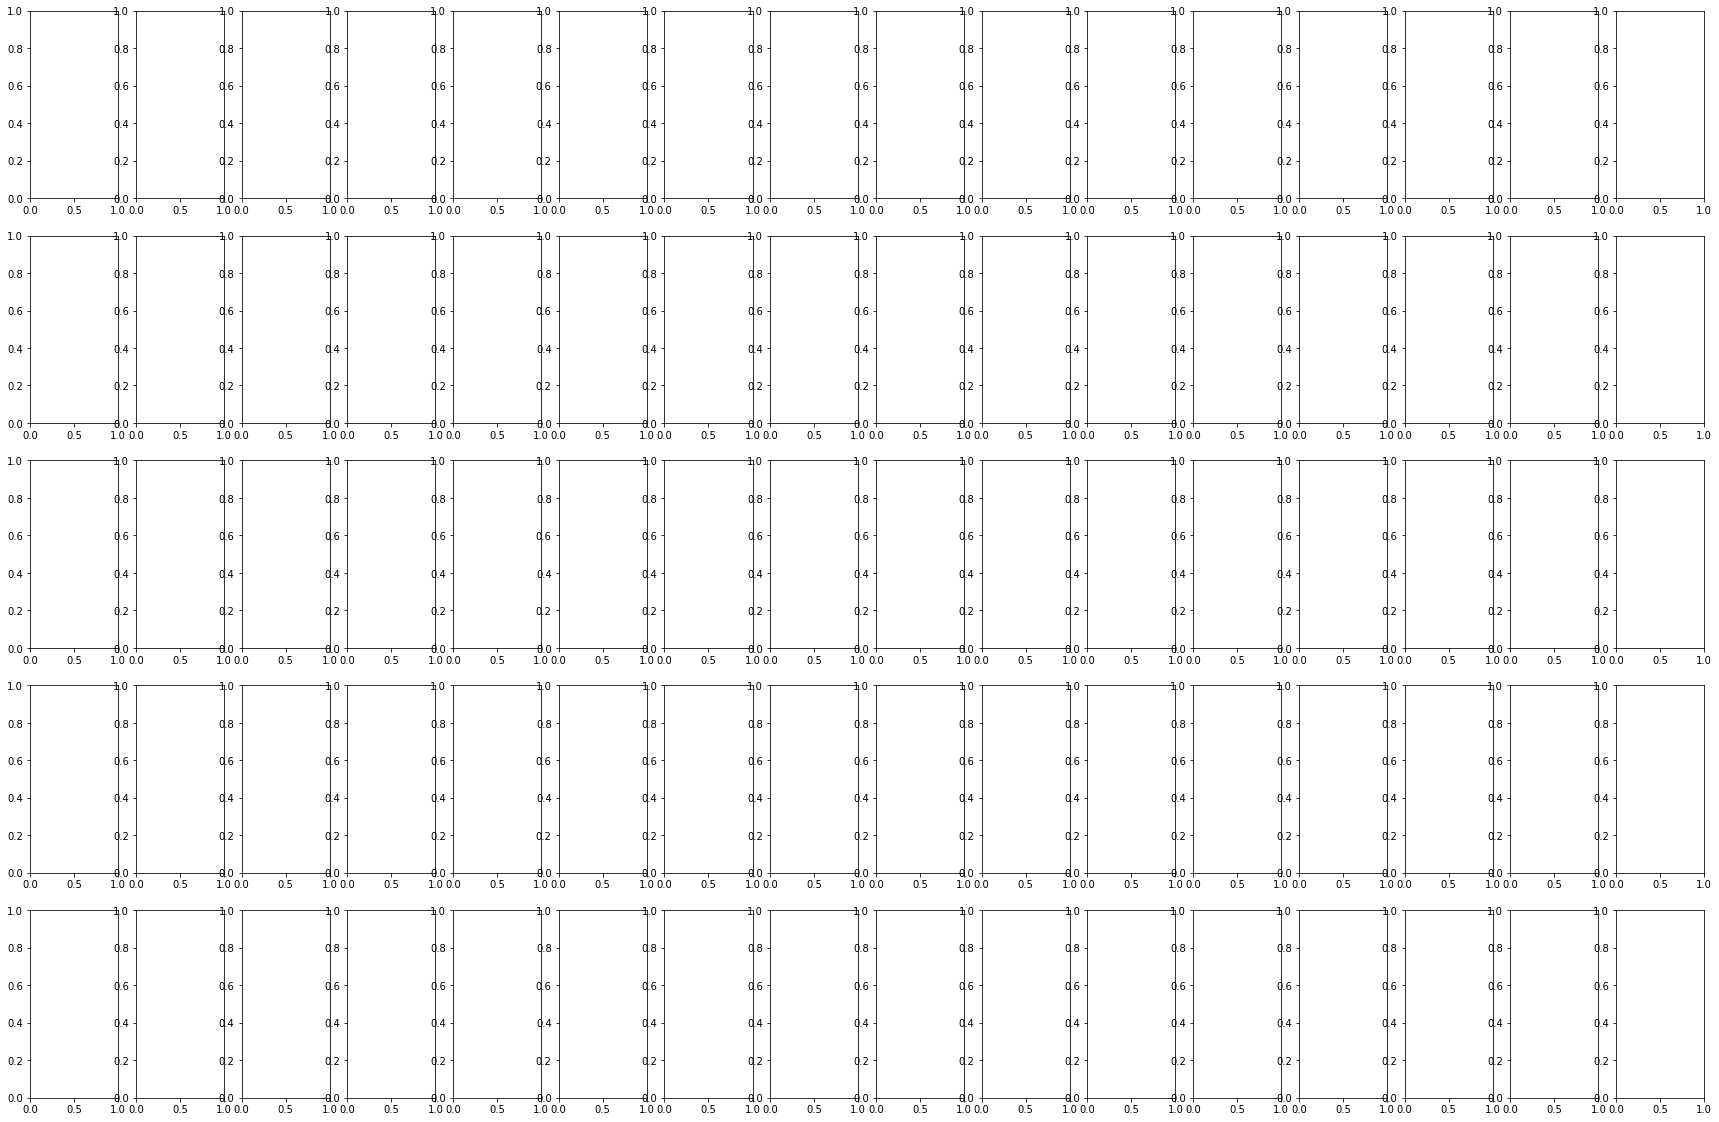

In [35]:
#  rita ut resultat

_, axes = plt.subplots(len(learning_rates), 2*len(drop_rates), figsize = (30, 20))

for i, metrics_row in enumerate(metrics_grid):
        for j, metrics in enumerate(metrics_row):
                
                metrics[["loss", "val_loss"]].plot(ax = axes[i, 2*j], title = f"Loss lr={learning_rates[i]} dr={drop_rates[j]}", grid = True)
                metrics[["acc", "val_acc"]].plot(ax = axes[i, 2*j+1], title = f"Accuracy lr={learning_rates[i]} dr={drop_rates[j]}", grid = True)

plt.show()
        

### b)